# Workshop 5, Stats for AI - Bloque 2

In [28]:
print("Victor Adid Salgado Santana A01710023")

Victor Adid Salgado Santana A01710023


In [29]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import pandas_datareader as pdr
import matplotlib.ticker as mticker
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

## CHALLENGE 1
Download the Real Gross Domestic Product for Mexico from the FRED online site (US Federal Reserve Bank). Use the ticker NGDPRNSAXDCMXQ. You have to:
* Calibrate an ARIMA-SARIMA to forecast the Mexico GDP for the the rest of 2025 and all quarters of 2026.

* You have to explain your calibration steps, and

* Interpret the final model.

In [30]:
# prompt: Download the series NGDPRNSAXDCMXQ from the FRED site since 1993, and using pandas_reader
# Install the pandas_datareader:
#!pip install pandas_datareader

# This part is already done in the preceding code.
series_id = "NGDPRNSAXDCMXQ"
mxgdpdf = pdr.get_data_fred(series_id,start='1993-01-01')
mxgdpdf.columns=['MXGDP']
print(mxgdpdf.head())

                MXGDP
DATE                 
1993-01-01  3439763.5
1993-04-01  3472286.3
1993-07-01  3465719.7
1993-10-01  3519338.2
1994-01-01  3525020.1


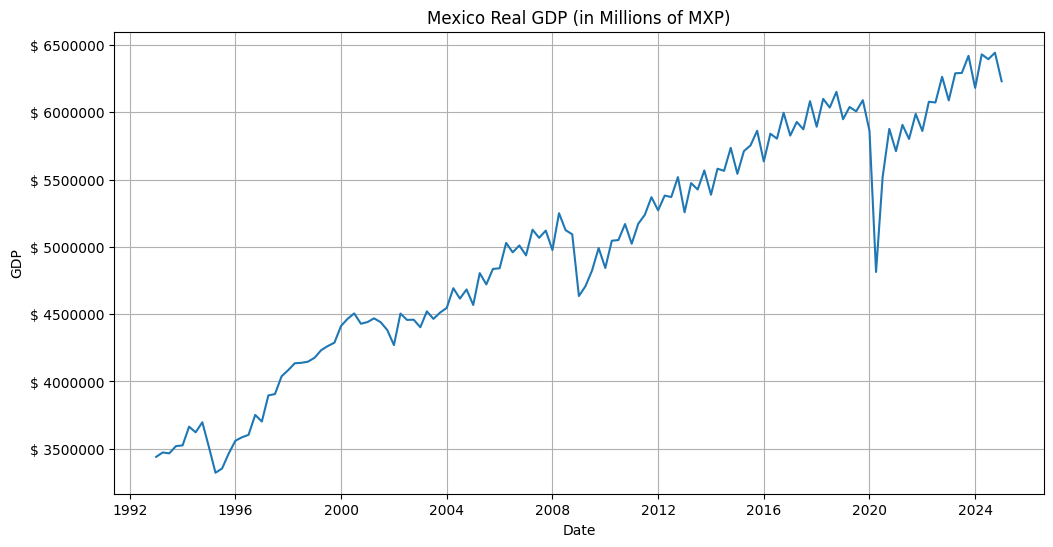

In [31]:

plt.figure(figsize=(12, 6))
plt.plot(mxgdpdf.index, mxgdpdf['MXGDP'])
plt.title('Mexico Real GDP (in Millions of MXP)')
plt.xlabel('Date')
plt.ylabel('GDP')
# Format the y-axis to show in currency format
formatter = mticker.FormatStrFormatter('$ %1.0f')
plt.gca().yaxis.set_major_formatter(formatter)

plt.grid(True)
plt.show()

Sacamos logaritmo a la serie y calculamos la diferencia logarítmica anual (esto significaría el crecimiento anual del PIB mexicano), ya que es lo recomendado para este tipo de datos, con estas transformaciones es posible que la serie ya sea estacionaria

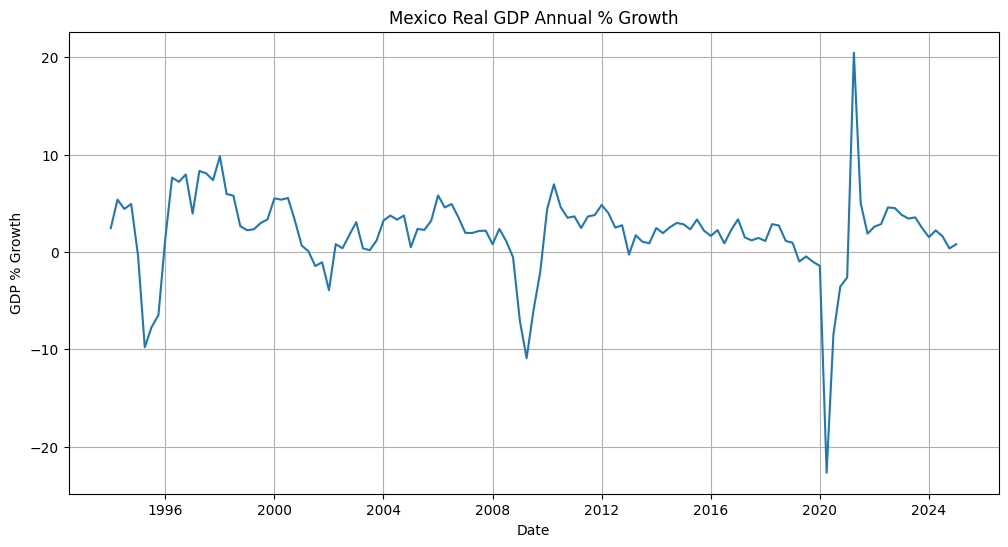

In [32]:
mxgdpdf['logMXGDP'] = np.log(mxgdpdf['MXGDP'])
mxgdpdf['annualgrowth'] = mxgdpdf['logMXGDP'] - mxgdpdf['logMXGDP'].shift(4) #ya que es trimestral, hay 4 periodos por año
plt.figure(figsize=(12, 6))
plt.plot(mxgdpdf.index, 100*mxgdpdf['annualgrowth'])
plt.title('Mexico Real GDP Annual % Growth')
plt.xlabel('Date')
plt.ylabel('GDP % Growth')
plt.grid(True)
plt.show()

Checamos estacionariedad aplicando la prueba de Dicky Fuller:
* $H_0$: La serie es NO ESTACIONARIA
* $H_1$: La serie es ESTACIONARIA

In [33]:
dftest = adfuller(mxgdpdf['annualgrowth'].dropna())
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.527930
p-value: 0.007298
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


Dado que el p-value para la prueba de Dicky Fuller es < 0.05, se tiene evidencia estadística para rechazar H0, lo que sugiere que el crecimiento anual del PIB mexicano es ESTACIONARIO

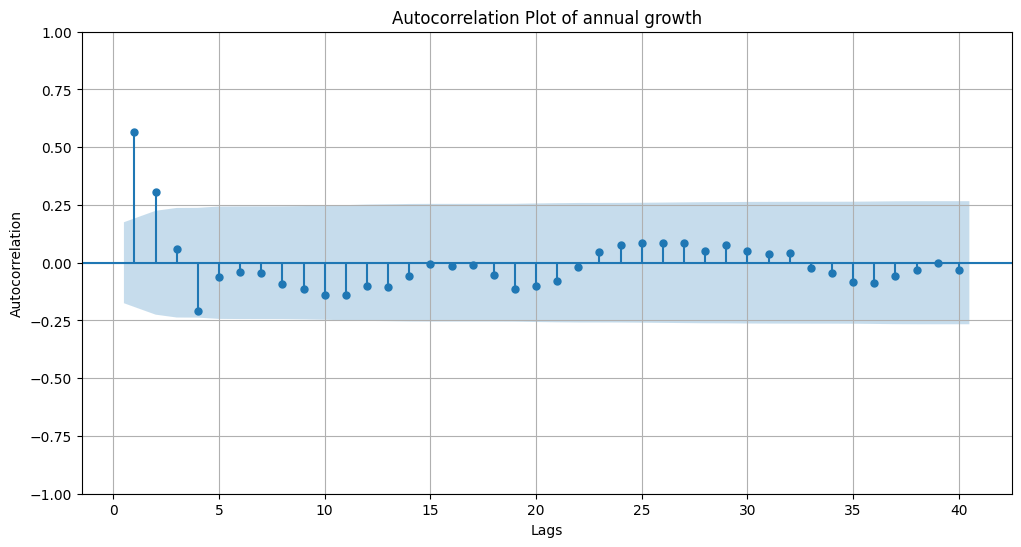

In [34]:
annual_growth = mxgdpdf.dropna(subset=['annualgrowth'])
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(annual_growth['annualgrowth'], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of annual growth')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

La gráfica de autocorrelaciones muestra que los primeros 2 LAGS son significativos, observando la gráfica notamos que los valores del crecimiento anual están autocorrelacionados a más del 50% con el periodo anterior (t-1) y más de un 25% con los valores del crecimiento anual 2 periodos anteriores.

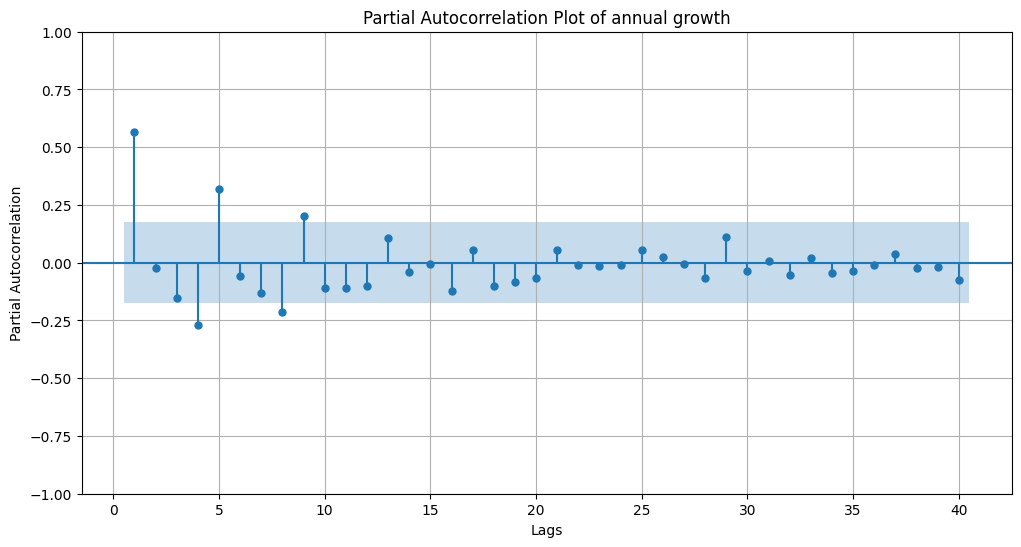

In [35]:
# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(annual_growth['annualgrowth'], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of annual growth')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

Con la autocorrelación parcial se modifica la influencia de los LAGS, el 2 LAG ya no es significativo, se conserva la autocorrelación significativa del LAG 1, mientras que se añade como significativos los LAGS 4 y 5

In [36]:
mxgdp_log = mxgdpdf['logMXGDP'].dropna() #Tomamos el logaritmo del PIB

# Fit SARIMA model ARIMA(p=1,d=0,q=0) SARIMA(P=0,D=1,Q=0,#periods=4)
model = SARIMAX(mxgdp_log, order=(1, 0, 0), #Tomamos p=1,d=0,q=0
                seasonal_order=(0, 1, 0, 4), #Tomamos P=0,D=1,Q=0,periods=4
                trend='c')

result = model.fit()
print(result.summary())
phi0 = result.params['intercept']
phi1= result.params['ar.L1']

print('phi0 = intercept = %f' % phi0)
print('phi1 = ar.L1 = %f' % phi1)

                                     SARIMAX Results                                     
Dep. Variable:                          logMXGDP   No. Observations:                  129
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 4)   Log Likelihood                 237.829
Date:                         mié., 12 nov. 2025   AIC                           -469.658
Time:                                   15:01:36   BIC                           -461.173
Sample:                               01-01-1993   HQIC                          -466.211
                                    - 01-01-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0084      0.003      2.572      0.010       0.002       0.015
ar.L1          0.5634      0.063      9.003

c:\Users\vcsalgado\Documents\Adid\tec\tec7\IA2\estadistica\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\vcsalgado\Documents\Adid\tec\tec7\IA2\estadistica\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


La variable a predecir es el logaritmo del PIB mexicano. Como los periodos son trimestrales se coloca el 4, como D=1,esto significa que se está modelando el % de crecimiento anual del PIB, ya que se calculó esa diferencia de logaritmo para el año anterior. Al usar solo el término p=1 se está modelando el AR tomando solo el trimestre anterior como variable explicativa, este coeficiente resulta significativo para el modelo, ya que su p-value es menor a 0.05 Esto significa que el crecimiento anual de un trimestre está autocorrelacionado en un 56% con el cambio anual del trimestre pasado

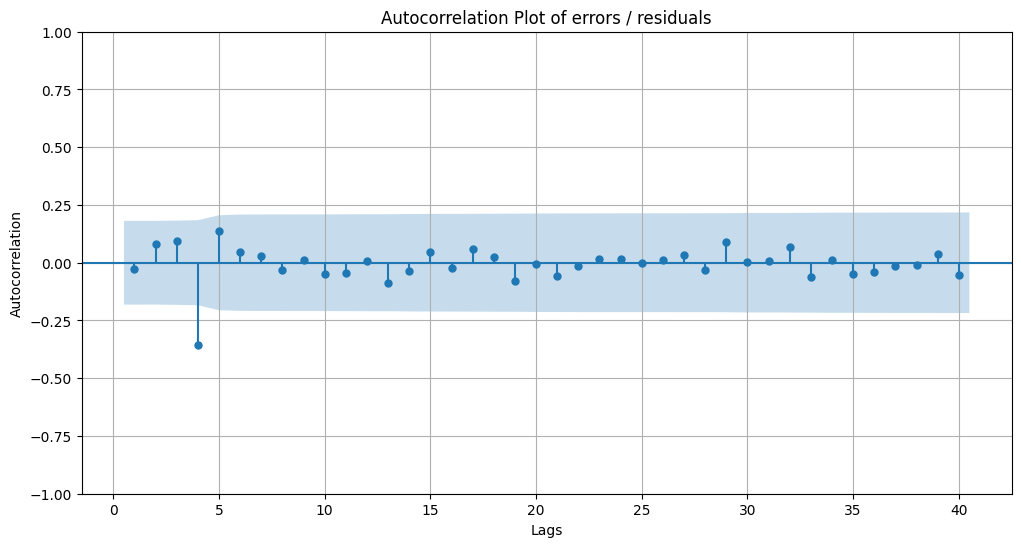

In [37]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

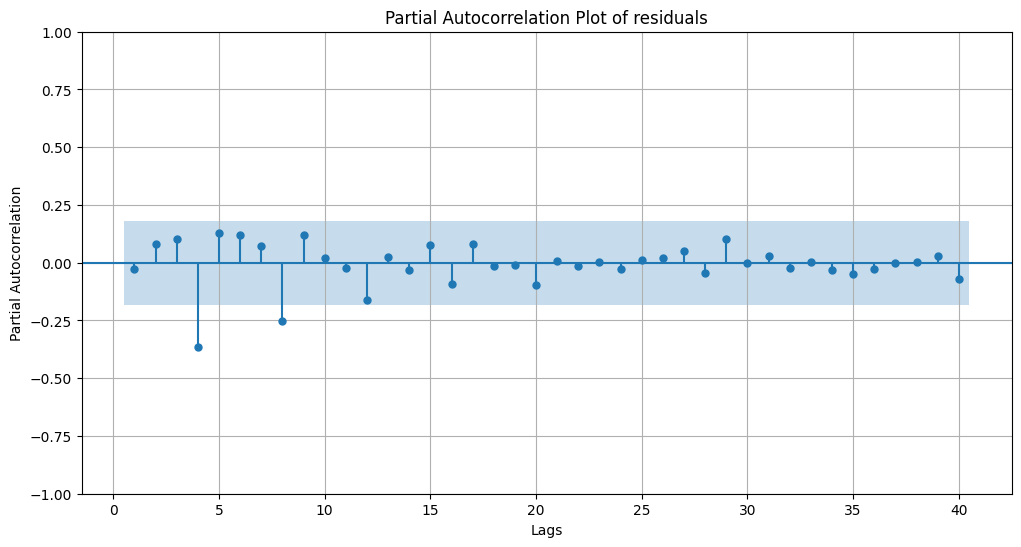

In [38]:
# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

En ambas gráficas AC y PAC se tiene que la autocorrelación con el LAG 4 es significativo y negativo. Cómo es 4 periodo (trimestre) pasado, se refiere al trimestre de hace un año. Debido a que se tiene autocorrelaciones negativas se piensa en añadir algún término de MA que trabaje con los residuos, y como es del año pasado, siguiendo la rule of thumb, se empieza modificando Q = 1 (y después P = 1). Cómo se detecta el patrón en el Lag 4 en ambas gráficas se le añadirá el término Q de SARIMA

In [39]:
model = SARIMAX(mxgdp_log, order=(1, 0, 0), 
                seasonal_order=(0, 1, 1, 4),
                trend='c')
result = model.fit()
print(result.summary())
phi0 = result.params['intercept']
phi1= result.params['ar.L1']
theta1 = result.params['ma.S.L4']
print('phi0 = intercept = %f' % phi0)
print('phi1 = %f' % phi1)
print('theta1 = %f' % theta1)

c:\Users\vcsalgado\Documents\Adid\tec\tec7\IA2\estadistica\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\vcsalgado\Documents\Adid\tec\tec7\IA2\estadistica\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                            logMXGDP   No. Observations:                  129
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 4)   Log Likelihood                 262.560
Date:                           mié., 12 nov. 2025   AIC                           -517.121
Time:                                     15:01:37   BIC                           -505.807
Sample:                                 01-01-1993   HQIC                          -512.525
                                      - 01-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0039      0.001      5.023      0.000       0.002       0.005
ar.L1          0.7929      

Se sigue modelando el % de crecimiento anual del PIB, por periodo trimestral, considerando 1 periodo anterior para predecir el actual (p=1) y se añade el término Q=1, el cuál ahora va a considerar los residuos del año anterior MA(1). Con el modelo modificado, los coeficientes resultantes también son significativos para el modelo.
Se modifican los coeficientes, dando como resultado p(1)= 0.7929 (referente al poder explicativo del trimestre pasado) y Q(1) = -0.8357 (referente a los residuos)
Esto significa que ahora, los valores del % de crecimiento anual del trimestre pasado están autocorrelacionados en un 79% con el crecimiento anual del trimestre actual, por otro lado el crecimiento % anual del PIB está relacionado negativamente con los errores (shocks) del año pasado (4 trimestres atrás) en un-83%

Igual que el proceso anterior, se analizan los residuos.

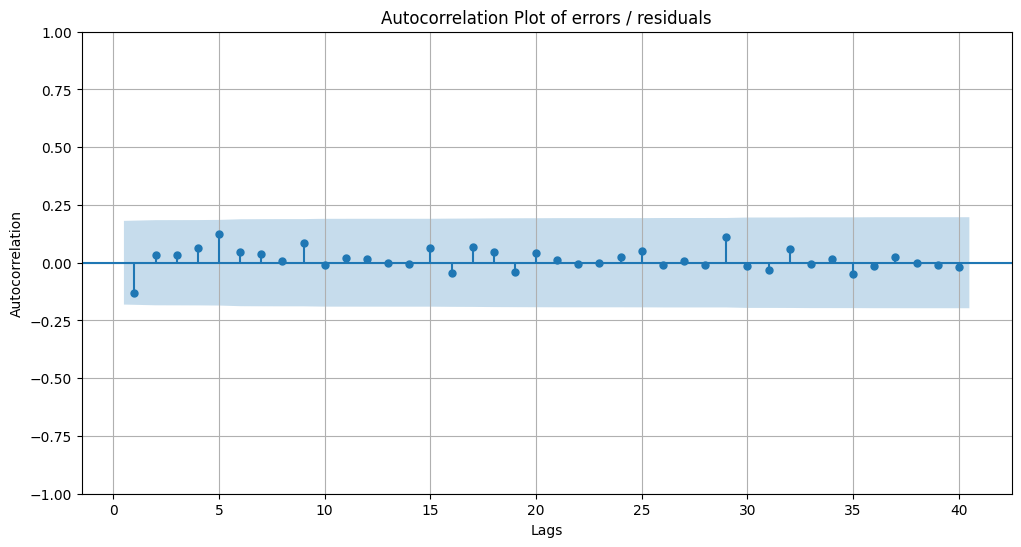

In [40]:
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

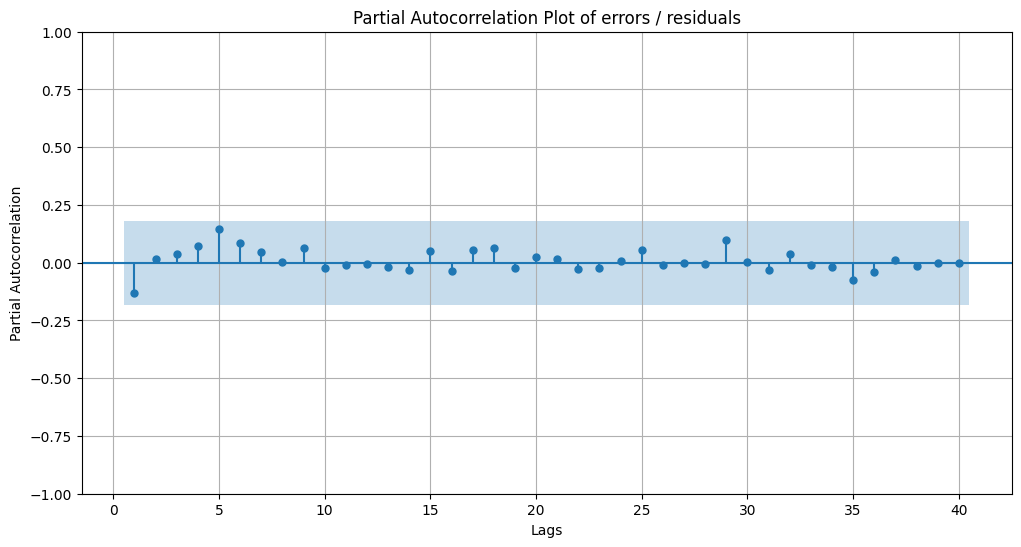

In [41]:
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

En el análisis de los residuos autocorrelacionados, tanto los AC como los PAC, no muestran residuos autocorrelacionados significativos.
Por lo tanto, el modelo queda así: 
* (p = 1, d = 0, q = 0)
* (P = 0, D = 1, Q = 1)

* phi0 = intercept = 0.003898
* phi1 = 0.792861
* theta1 = -0.835651
* ARIMA_SARIMA ecuación:
$Y_t = 0.003898 + 0.792861 * Y_{t-1} -0.835651 * error_{t-4} + error_t$ 

Cómo se trabaja con el logaritmo del GDP de México y se tiene Q=1 esto significa que se está modelando el % de cambio anual de México (Y)
* $\phi_1$: AR(1) = 0.79, esto significa que el % de cambio del GDP Mexico anual es positivo y está relacionado significativamente en un 79% con el propio % de cambio GDP del trimestre pasado. Por lo que si el trimestre pasado el % de cambio anual del GDP de México era positivo, es probable que ese el % de cambio anual del GDP de México del trimestre actual sea positivo
* $\theta_1$: MA(1) = -0.83. Esto significa que el % de cambio del GDP anual es negativo y está significativamente autocorrelacionado en un 83$ con los shocks del trimestre del año pasado

In [42]:
mxgdpdf.tail()

,MXGDP,logMXGDP,annualgrowth
DATE,,,
2024-01-01,6180421.9,15.636897,0.015122
2024-04-01,6429466.3,15.676402,0.022093
2024-07-01,6393539.8,15.670799,0.016068
2024-10-01,6441773.9,15.678315,0.003568
2025-01-01,6229814.4,15.644857,0.007960


Cómo se quiere predecir para los valores restantes del 2025 y todo 2026, se ocupa predecir los próximos 7 periodos (3 restantes del 2025, ya que solo se tiene 1 periodo)

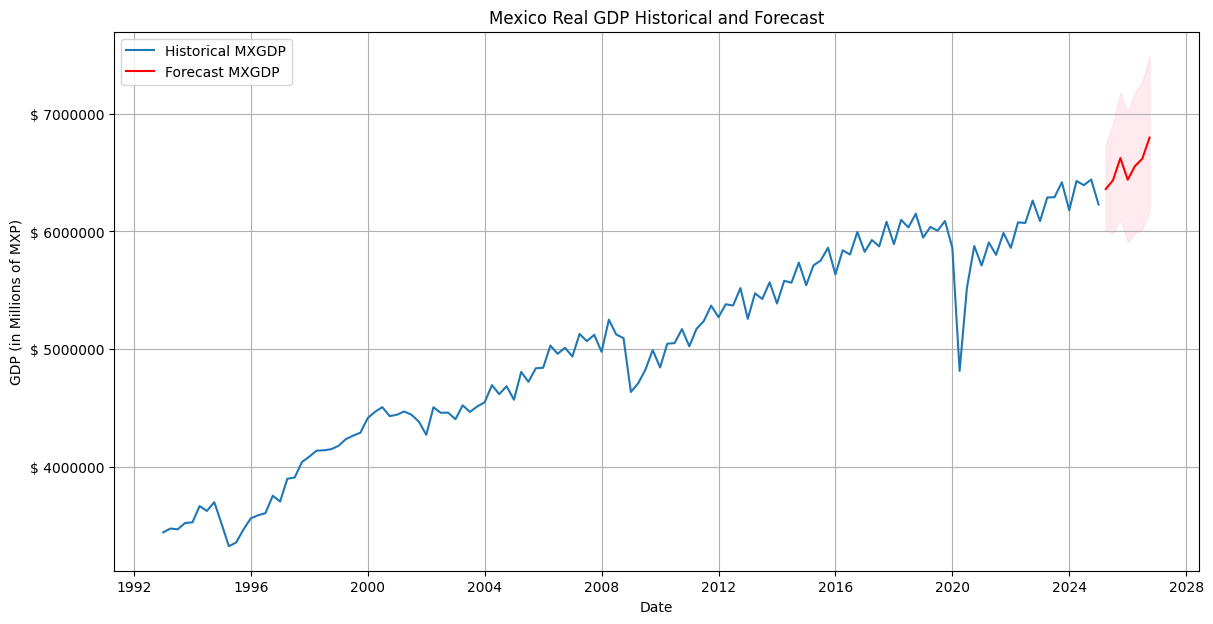

In [43]:
forecast_steps = 7
forecast_result = result.get_forecast(steps=forecast_steps)
forecast_log = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int(alpha=0.05)
forecast_values = np.exp(forecast_log)

plt.figure(figsize=(14, 7))
plt.plot(mxgdpdf.index, mxgdpdf['MXGDP'], label='Historical MXGDP')
plt.plot(forecast_values.index, forecast_values, label='Forecast MXGDP', color='red')
plt.fill_between(forecast_values.index, np.exp(forecast_ci.iloc[:, 0]), np.exp(forecast_ci.iloc[:, 1]), color='pink', alpha=0.3) # Plot confidence interval
plt.title('Mexico Real GDP Historical and Forecast')
plt.xlabel('Date')
plt.ylabel('GDP (in Millions of MXP)')
formatter = mticker.FormatStrFormatter('$ %1.0f')
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.legend()
plt.show()

## CHALLENGE 2
Do the same as above, but now for the US Real GDP: Download the Real Gross Domestic Product for the US from the FRED online site (US Federal Reserve Bank). Use the ticker NGDPRNSAXDCMXQ. You have to:

* Calibrate an ARIMA-SARIMA to forecast the US GDP for the the rest of 2025 and all quarters of 2026.

* Using your previous Mexico SARIMA model, use the US GDP annual % growth as an explanatory variable (exogenous variable).

* Interpret the final model.

In [44]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import pandas_datareader as pdr
import matplotlib.ticker as mticker
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [45]:
series_id = "GDPC1"
usgdpdf = pdr.get_data_fred(series_id,start='1993-01-01')
usgdpdf.columns=['USGDP']
print(usgdpdf.head())

                USGDP
DATE                 
1993-01-01  10576.275
1993-04-01  10637.847
1993-07-01  10688.606
1993-10-01  10833.987
1994-01-01  10939.116


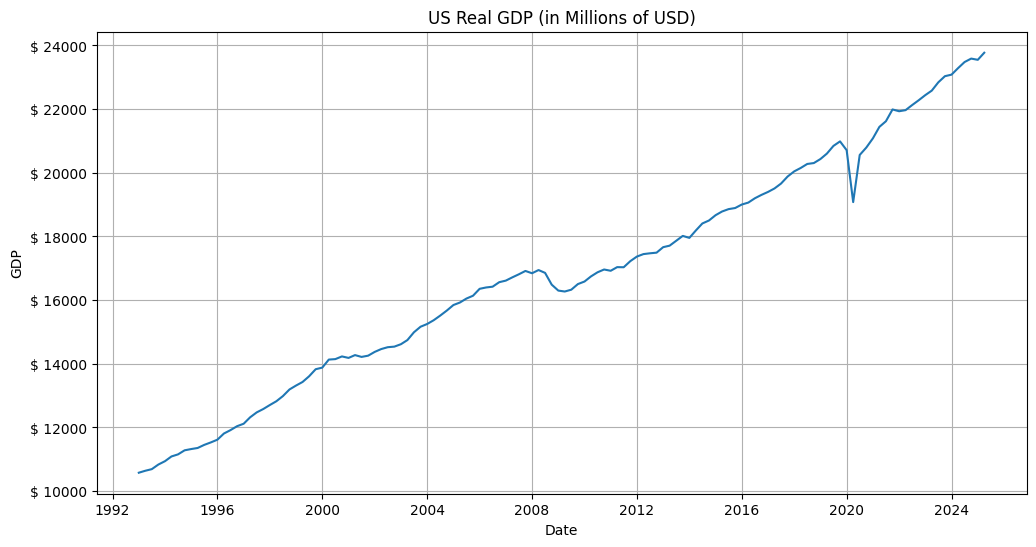

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(usgdpdf.index, usgdpdf['USGDP'])
plt.title('US Real GDP (in Millions of USD)')
plt.xlabel('Date')
plt.ylabel('GDP')
# Format the y-axis to show in currency format
formatter = mticker.FormatStrFormatter('$ %1.0f')
plt.gca().yaxis.set_major_formatter(formatter)

plt.grid(True)
plt.show()

Al igual que en el challege 1 se saca la diferencia entre años, indicando que se trata de crecimiento anual

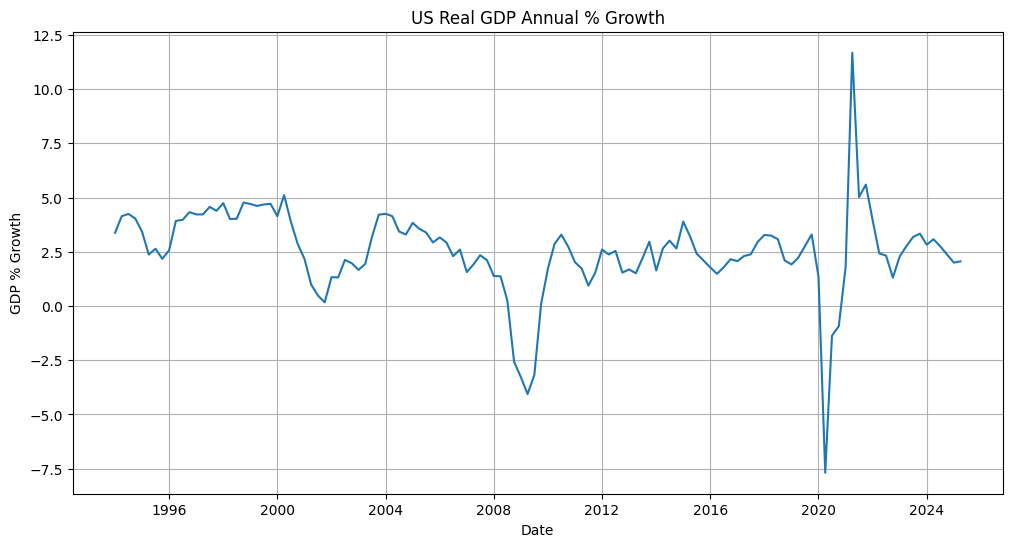

In [47]:
usgdpdf['logUSGDP'] = np.log(usgdpdf['USGDP'])
usgdpdf['annualgrowth'] = usgdpdf['logUSGDP'] - usgdpdf['logUSGDP'].shift(4) #ya que es trimestral, hay 4 periodos por año
plt.figure(figsize=(12, 6))
plt.plot(usgdpdf.index, 100*usgdpdf['annualgrowth'])
plt.title('US Real GDP Annual % Growth')
plt.xlabel('Date')
plt.ylabel('GDP % Growth')
plt.grid(True)
plt.show()

In [48]:
dftest = adfuller(usgdpdf['annualgrowth'].dropna())
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.568448
p-value: 0.099695
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


Dado que el p-value para la prueba de Dicky Fuller es > 0.05, no se tiene evidencia estadística para rechazar H0, lo que sugiere que la serie NO es ESTACIONARIA.

Entonces, el crecimiento anual del GDP (PIB) de USA NO es estacionaria.

Ahora se procede a calcular la diferencia por periodo (trimestre) para probar si esta serie resulta ESTACIONARIA

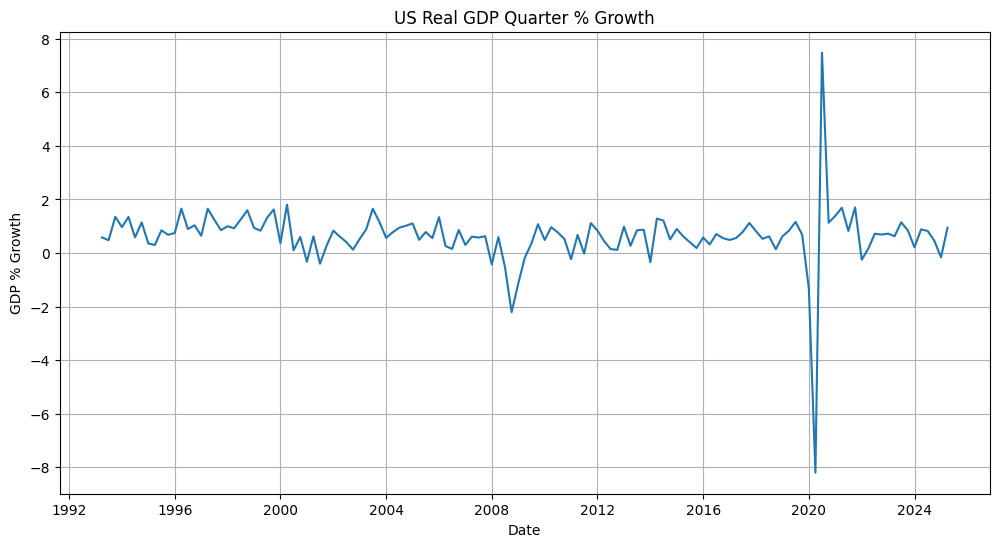

In [49]:
usgdpdf['quartergrowth'] = usgdpdf['logUSGDP'] - usgdpdf['logUSGDP'].shift(1) #Diferencia por trimestres
plt.figure(figsize=(12, 6))
plt.plot(usgdpdf.index, 100*usgdpdf['quartergrowth'])
plt.title('US Real GDP Quarter % Growth')
plt.xlabel('Date')
plt.ylabel('GDP % Growth')
plt.grid(True)
plt.show()

In [50]:
dftest = adfuller(usgdpdf['quartergrowth'].dropna())
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -13.103152
p-value: 0.000000
Critical Values:
	1%: -3.483
	5%: -2.884
	10%: -2.579


Al aplicar una diferenciación por trimestres la serie se vuelve ESTACIONARIA, esto se puede confirmar con la prueba de DF, el pvalue resultante es <0.05. Esto significa el porcentaje de crecimiento trimestral

#### **Modelado y ajuste**

Recordamos que tomamos la diferencia por periodo para hacer estacionaria la serie del GDP de EEUU. d = 1

In [51]:
usgdpdf_log = usgdpdf['logUSGDP'].dropna() #Tomamos el logaritmo del PIB
model = SARIMAX(usgdpdf_log, order=(1, 1, 0), 
                seasonal_order=(0, 0, 0, 4),
                trend='c')
result = model.fit()
print(result.summary())
phi0 = result.params['intercept']
phi1= result.params['ar.L1']
print('phi0 = intercept = %f' % phi0)
print('phi1 = %f' % phi1)

                               SARIMAX Results                                
Dep. Variable:               logUSGDP   No. Observations:                  130
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 395.084
Date:              mié., 12 nov. 2025   AIC                           -784.167
Time:                        15:01:38   BIC                           -775.588
Sample:                    01-01-1993   HQIC                          -780.681
                         - 04-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0072      0.002      4.425      0.000       0.004       0.010
ar.L1         -0.1538      0.036     -4.275      0.000      -0.224      -0.083
sigma2         0.0001   5.19e-06     24.683      0.0

c:\Users\vcsalgado\Documents\Adid\tec\tec7\IA2\estadistica\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\vcsalgado\Documents\Adid\tec\tec7\IA2\estadistica\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


Cómo se estaba usando el log del GDP y se le aplico la diferenciacion (d=1) entonces se está modelando el % de crecimiento trimestral del PIB de USA. En este caso el valor del AR(1) es significativo, ya que su pvalue es 0. Esto significa que el % de crecimiento trimestral del PIB de USA está autocorrelacionada negativa y significativamente en un -15% con el trimestre anterior

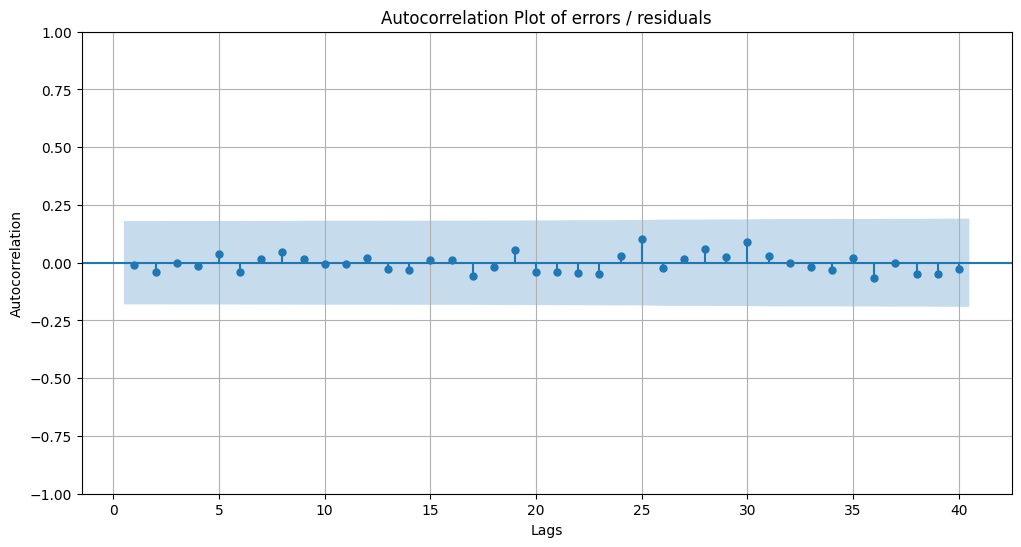

In [52]:
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

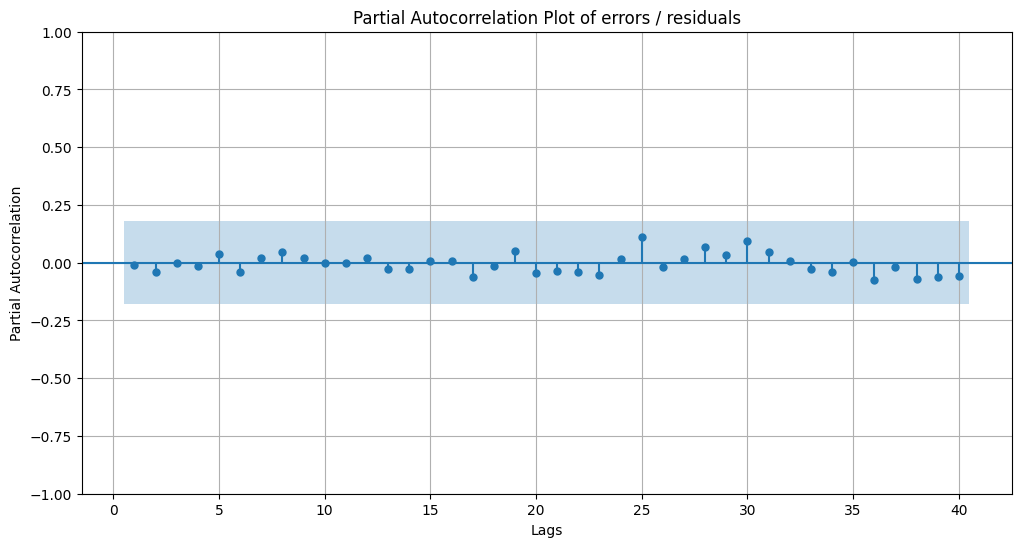

In [53]:
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

En el análisis de los residuos autocorrelacionados, tanto los AC como los PAC, no muestran residuos autocorrelacionados significativos.
Por lo tanto, el modelo queda así: 
* (p = 1, d = 1, q = 0)
* (P = 0, D = 0, Q = 0)


* phi0 = intercept = 0.007240
* phi1 = -0.153776

Cómo se tiene d = 1, entonces se está hablando del % de crecimiento trimestral del PIB de USA. Colocando los coeficientes significativos se tiene la siguiente ecuación:
* $Y_t = -0.153776 * Y_{t-1} + error_t$ 

Los valores del crecimiento % trimestral del trimestre anterior están autocorrelacionados significativamente de forma negativa en un -15% con el crecimiento % del trimestre actual

**Predicciones**

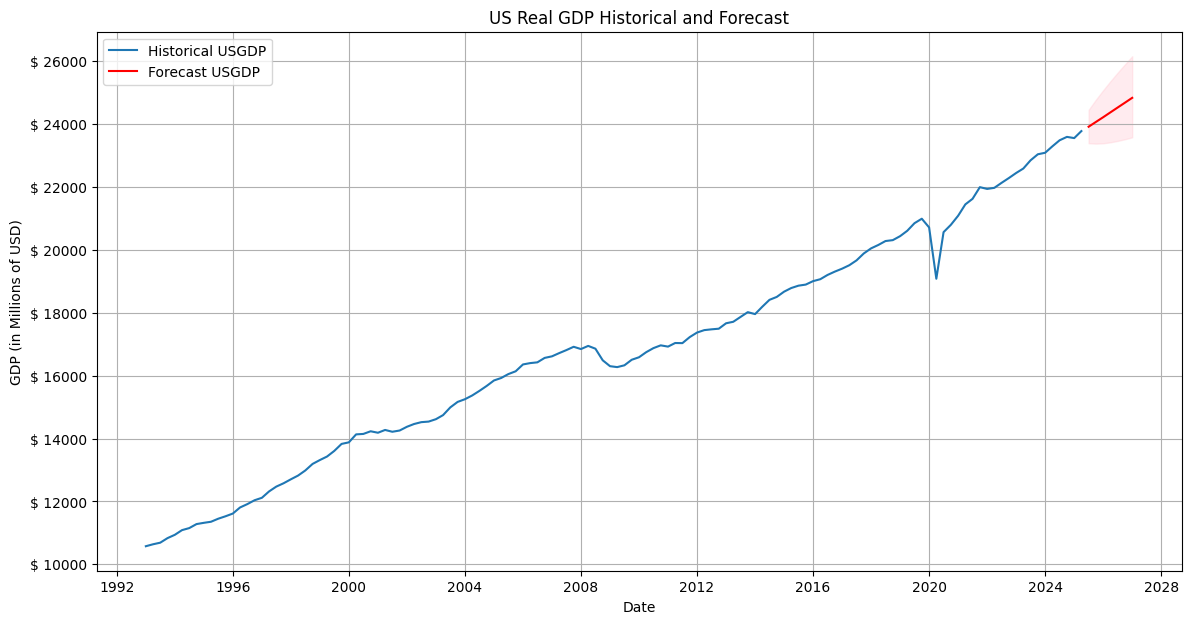

In [55]:
forecast_steps = 7
forecast_result = result.get_forecast(steps=forecast_steps)
forecast_log = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int(alpha=0.05)
forecast_values = np.exp(forecast_log)

plt.figure(figsize=(14, 7))
plt.plot(usgdpdf.index, usgdpdf['USGDP'], label='Historical USGDP')
plt.plot(forecast_values.index, forecast_values, label='Forecast USGDP', color='red')
plt.fill_between(forecast_values.index, np.exp(forecast_ci.iloc[:, 0]), np.exp(forecast_ci.iloc[:, 1]), color='pink', alpha=0.3) # Plot confidence interval
plt.title('US Real GDP Historical and Forecast')
plt.xlabel('Date')
plt.ylabel('GDP (in Millions of USD)')
formatter = mticker.FormatStrFormatter('$ %1.0f')
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.legend()
plt.show()

**Modelo Final: SARIMAX**

Using your previous Mexico SARIMA model, use the US GDP annual % growth as an explanatory variable

Primero se crea un modelo simple con únicamente el término p = 1 y D = 1, indicando el modelo inicial del PIB de México (recordemos que el modelo del PIB de México solo ocupo una diferenciación), pero añadiendo ahora la variable del PIB de US

In [56]:
#SARIMAX de Mexico GDP con US GDP como variable exógena
usgdp_log = usgdpdf['logUSGDP'].dropna() #Tomamos el logaritmo del PIB
#dropear ultimo valor de usgdp_log para que coincida con mxgdp_log
usgdp_log = usgdp_log.iloc[:-1]
mxgdp_log = mxgdpdf['logMXGDP'].dropna() #Tomamos el logaritmo del PIB
model = SARIMAX(mxgdp_log, order=(1, 0, 0), 
            seasonal_order=(0, 1, 0, 4),
            exog=usgdp_log,
            trend='c')
result = model.fit()
print(result.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          logMXGDP   No. Observations:                  129
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 4)   Log Likelihood                 302.652
Date:                         mié., 12 nov. 2025   AIC                           -597.305
Time:                                   15:09:37   BIC                           -585.992
Sample:                               01-01-1993   HQIC                          -592.709
                                    - 01-01-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0111      0.003     -3.705      0.000      -0.017      -0.005
logUSGDP       1.9157      0.081     23.684

c:\Users\vcsalgado\Documents\Adid\tec\tec7\IA2\estadistica\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\vcsalgado\Documents\Adid\tec\tec7\IA2\estadistica\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


Los coeficientes son significativos y positivos. El término de AR(1) significa que el crecimiento % del PIB anual de México está autocorrelacionado con el crecimiento % del PIB anual del trimestre pasado. Por otro lado, el PIB de USA también es significativo, esto quiere decir que al aumentar 1% el PIB de USA, el PIB de México aumenta 1.9

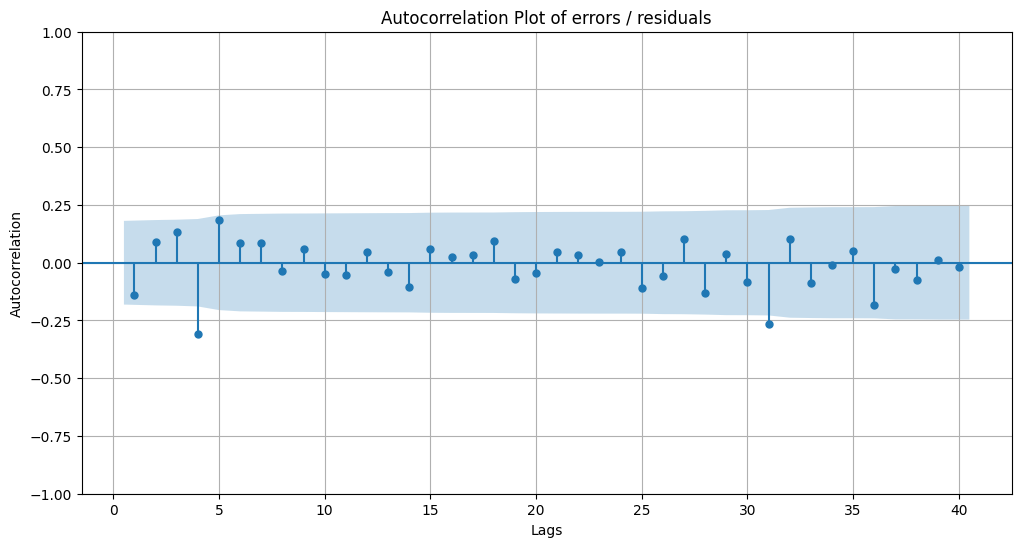

In [57]:
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

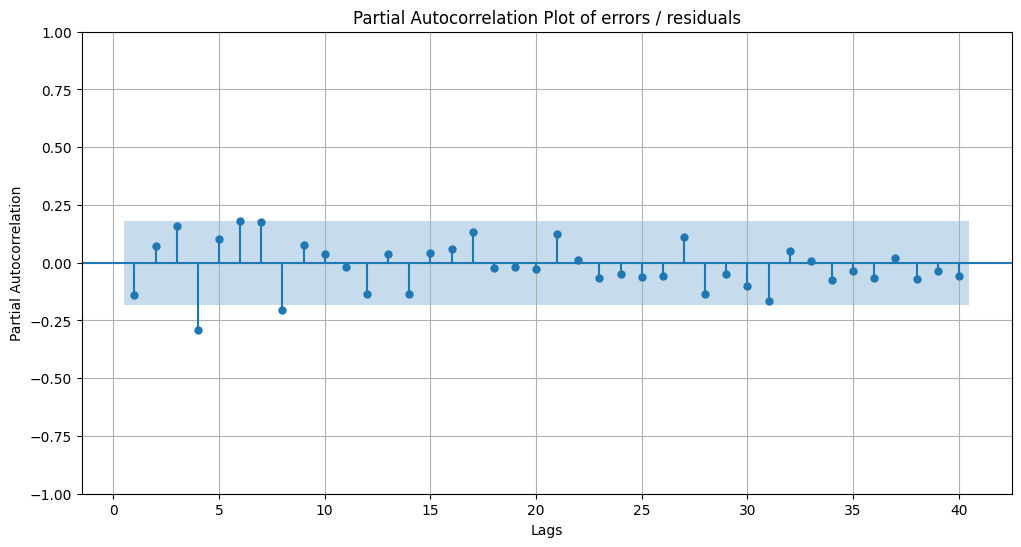

In [58]:
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

El AC y PAC muestran el LAG 4 como negativo y significativo, se está hablando del periodo hace 1 año. Por lo que se sugiere añadir un término para tomar en cuenta los valores del año pasado, se empieza con Q = 1

In [59]:
usgdp_log = usgdpdf['logUSGDP'].dropna()
mxgdp_log = mxgdpdf['logMXGDP'].dropna()
usgdp_log = usgdp_log.iloc[:-1]
model = SARIMAX(mxgdp_log, order=(1, 0, 0), 
            seasonal_order=(0, 1, 1, 4),
            exog=usgdp_log,
            trend='c')
result = model.fit()
print(result.summary())

c:\Users\vcsalgado\Documents\Adid\tec\tec7\IA2\estadistica\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\vcsalgado\Documents\Adid\tec\tec7\IA2\estadistica\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                            logMXGDP   No. Observations:                  129
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 4)   Log Likelihood                 318.853
Date:                           mié., 12 nov. 2025   AIC                           -627.707
Time:                                     15:09:51   BIC                           -613.565
Sample:                                 01-01-1993   HQIC                          -621.962
                                      - 01-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0038      0.002     -2.513      0.012      -0.007      -0.001
logUSGDP       1.9381      

Este modelo con Q = 1 y el log de mxn, modela el crecimiento anual del PIB de México. Los coeficientes son significativos:
* $\phi_1$: Los valores del crecimiento anual del trimestre anterior del PIB MXN estan autocorrelacionados positivamente con el crecimiento anual del trimestre actual.
* $\theta_1$: Los valores de los residuos trimestre del año pasado estan autocorrelacionados negativamente con el crecimiento del PIB.
* $logUSD$: Correlacionado positivamente


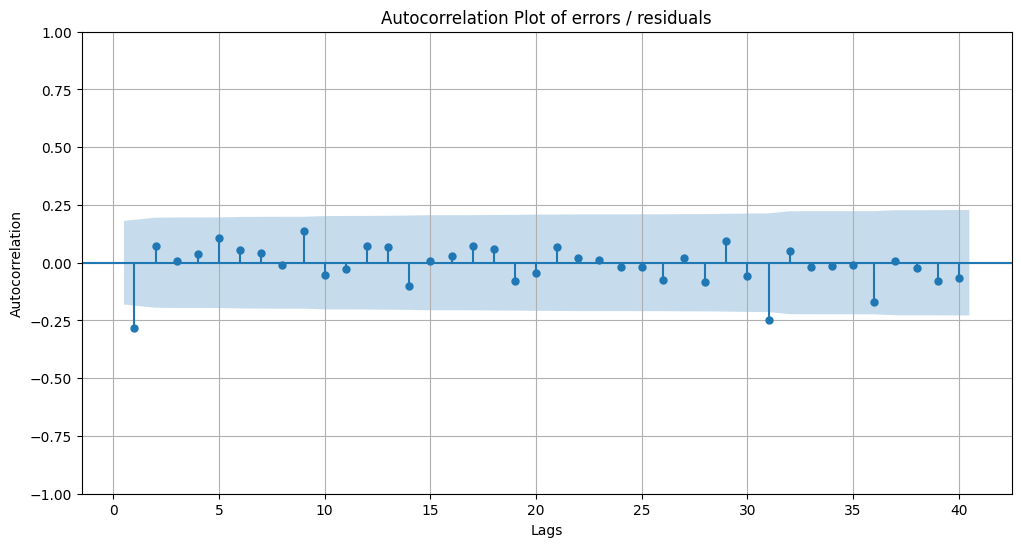

In [60]:
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

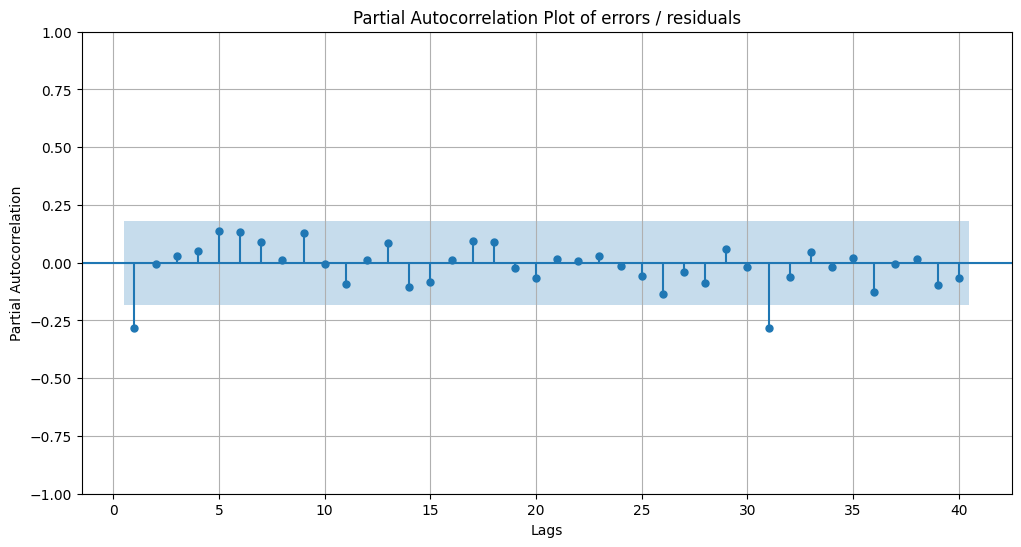

In [61]:
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

Las gráficas de AC y PAC muestra una autocorrrelación negativa con los LAGS del 1 periodo, se puede añadir un término q=1 que tome en cuenta los residuos 

In [62]:
usgdp_log = usgdpdf['logUSGDP'].dropna()
mxgdp_log = mxgdpdf['logMXGDP'].dropna()
usgdp_log = usgdp_log.iloc[:-1]
model = SARIMAX(mxgdp_log, order=(1, 0, 1), 
            seasonal_order=(0, 1, 1, 4),
            exog=usgdp_log,
            trend='c')
result = model.fit()
print(result.summary())

c:\Users\vcsalgado\Documents\Adid\tec\tec7\IA2\estadistica\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\vcsalgado\Documents\Adid\tec\tec7\IA2\estadistica\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                          logMXGDP   No. Observations:                  129
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 4)   Log Likelihood                 320.544
Date:                         mié., 12 nov. 2025   AIC                           -629.087
Time:                                   15:10:23   BIC                           -612.117
Sample:                               01-01-1993   HQIC                          -622.193
                                    - 01-01-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0031      0.002     -1.732      0.083      -0.007       0.000
logUSGDP       1.9881      0.079     25.054

c:\Users\vcsalgado\Documents\Adid\tec\tec7\IA2\estadistica\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


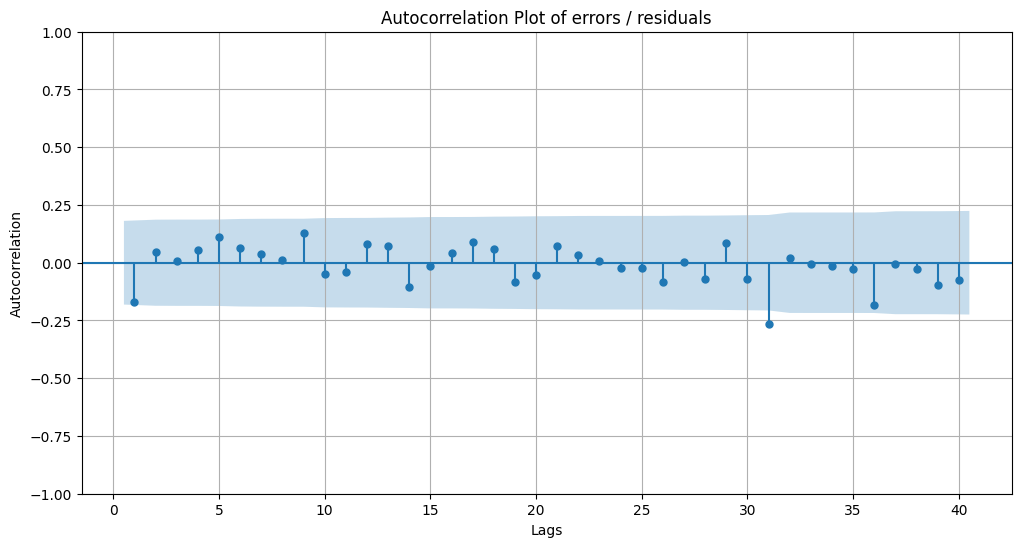

In [63]:
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

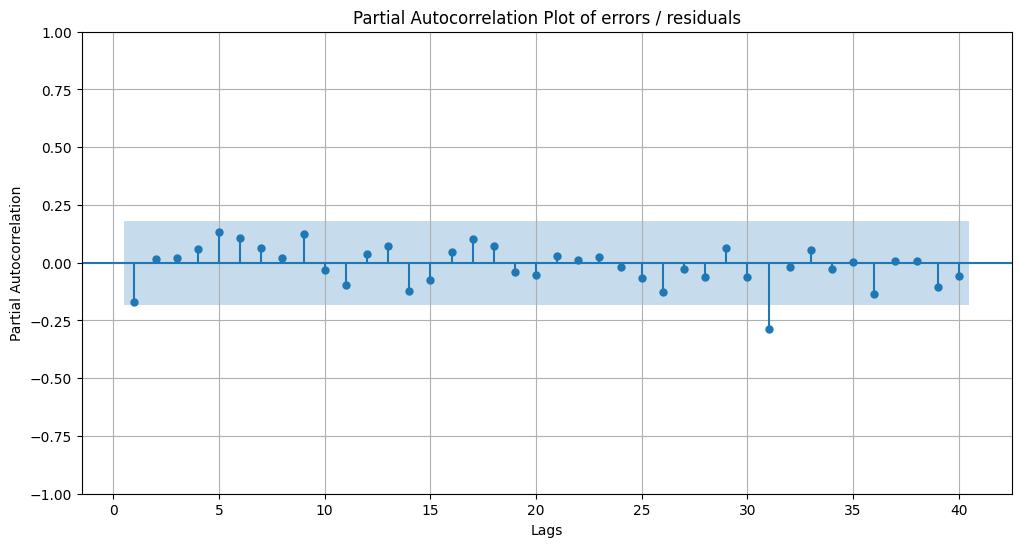

In [64]:
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

En el análisis de los residuos autocorrelacionados, tanto los AC como los PAC, no muestran un patrón visible o relacionado con residuos autocorrelacionados significativos (el 31 no se toma en consideración debido a que se tienen datos de forma trimestral, no hay algún residuo que esté presente en los múltiplos/años de la variable).
Por lo tanto, el modelo queda así: 
* (p = 1, d = 0, q = 1)
* (P = 0, D = 1, Q = 1)
    
* phi0 = intercept = -0.0031
* phi1 = 0.8906
* theta1 = -0.1391 
* theta2 = -0.6924
* logUSD = 1.9881  

Cómo se tiene Q = 1, entonces se está hablando de Y= el crecimiento anual del PIB de México:

Colocando únicamente los coeficientes significativos
* ARIMA_SARIMA ecuación:
$Y_t = 0.8906 * Y_{t-1} -0.1391 * error_{t-1}-0.6924 * error_{t-4} + 1.9881 * logUSD + error_t$ 


Los valores del crecimiento anual del PIB de México estan autocorrelacionados con los valores del crecimiento anual del trimestre pasado en un 89%, además de que los errores del año pasado están correlacionados negativamente con el crecimiento anual (-0.6924), los errores del trimestre pasado también están autocorrelacionados significativamente y de forma negativa (-0.1391) con los valores del crecimiento % del PIB en México, por último, el logaritmo del PIB de USA está correlacionado positivamente con el crecimiento anual del PIB de México

In [ ]:
print("Victor Adid Salgado Santana A01710023")

Victor Adid Salgado Santana A01710023
